# Introduction

Previously we investigated ways to detect Covid-19 using biometric data generally referred to as vitals. The three metrics we looked at were Sp02, Pulse, and Temperature. We were able to generate a model that can predict with 95%+ accuracy if the user has Covid-19 or not using just these three metrics. We also decided that since Sp02 and Pulse are already tracked on an Apple Watch Series 6, a model that could evaluate based on just those two metrics would allow for an iOS app that monitors for Covid-19 without any activate effort from the user. We were able to generate a model with a 80% precision and 92% recall. This is high, but not good enough. I also am not certain if our model can differentiate between Covid-19 and the Flu. 

To overcome both these problems, we next will be exploring another dataset that takes lots of binary classification features and outputs a diagnosis of Cold, Flu, Allergies, and Covid-19. These features match potential symptoms the user may be experiencing such as cough, sore throad, etc. If we can accurately model these symptoms to a diagnosis, we can generate a system that accurately monitors and diagnosis Covid-19 for iOS users with an Apple Watch series 6. 

The proposal is to utilize the first model to monitor vitals in the background. If the model detects Covid-19, the user would be prompted to answer some further questions. These questions map to the dataset we are about to explore and could accurately help end users understand their health and make better informed decisions. 

In [3]:
# First I need to import my libraries

import numpy as np

import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder

import scipy.stats as stats
from scipy.stats import chi2_contingency

Each feature is a binary value of zero representing that the user is not experiencing that symptom and one if they are.

In [4]:
originalData_df = pd.read_csv('large_data.csv')
print("DataFrame shape: {}".format(originalData_df.shape))
originalData_df.head()

DataFrame shape: (44453, 21)


,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,ALLERGY
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,1,ALLERGY
2,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,ALLERGY
3,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,ALLERGY
4,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,ALLERGY


Looks like we have a very unbalanced dataset. This can be problematic for any model we attempt to build. Lets go ahead and only take 1024 records from each Type. We can use the entire dataset later on for testing our models.

** I originally set the amount of examples per targer class to 1024, but as I will discuss in the results section, the model failed to generalize to the larger dataset during testing. I was only getting about 50% precision for colds and Covid. If I set the sample size to 2048 per class, models are way more accurate as they must need more training data from the covid examples.

In [5]:
originalData_df['TYPE'].value_counts()

FLU        25000
ALLERGY    16381
COVID       2048
COLD        1024
Name: TYPE, dtype: int64

In [6]:
def sampling_k_elements(group, k=2048):
    if len(group) < k:
        return group
    return group.sample(k)

originalData_df = originalData_df.groupby('TYPE').apply(sampling_k_elements).reset_index(drop=True)
originalData_df.head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,ALLERGY
1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,ALLERGY
2,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,ALLERGY
3,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,1,1,0,ALLERGY
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,ALLERGY


The mean value for different symptoms. On average, half of data records had muscle aches, tiredness, sore throat, cough, and sneezing. Some values like itchyness and pink eye are rare on average. This might make them excellent indicators for a specific disease. 

In [7]:
describe_df = originalData_df.describe()
describe_df.loc['mean'].sort_values

<bound method Series.sort_values of COUGH                   0.496931
MUSCLE_ACHES            0.507952
TIREDNESS               0.513811
SORE_THROAT             0.507673
RUNNY_NOSE              0.360212
STUFFY_NOSE             0.370536
FEVER                   0.360491
NAUSEA                  0.293108
VOMITING                0.297294
DIARRHEA                0.297991
SHORTNESS_OF_BREATH     0.297294
DIFFICULTY_BREATHING    0.292690
LOSS_OF_TASTE           0.329939
LOSS_OF_SMELL           0.330776
ITCHY_NOSE              0.137835
ITCHY_EYES              0.146763
ITCHY_MOUTH             0.143694
ITCHY_INNER_EAR         0.143694
SNEEZING                0.515346
PINK_EYE                0.143555
Name: mean, dtype: float64>

Some noticable correlations:

1. all "itchy" symptoms correlate highly with each other
2. Fever shows some correlation with lots of other symptoms
3. Shortness of breath shows some correlation with lots of other symptoms

In [8]:
originalData_df.corr()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE
COUGH,1.000000,-0.008553,-0.004576,0.005396,-0.003531,-0.007423,0.002865,0.011002,-0.015237,-0.019183,-0.004249,-0.008316,0.012912,0.004612,-0.013734,0.001757,0.002515,0.004901,-0.004278,-0.001068
MUSCLE_ACHES,-0.008553,1.000000,0.015752,-0.011408,-0.004378,-0.008737,0.003750,0.012747,0.001559,0.012211,0.007054,0.002647,0.007533,0.003942,-0.013645,-0.000288,0.003030,0.007008,0.002583,0.004232
TIREDNESS,-0.004576,0.015752,1.000000,0.000693,-0.001547,0.005385,-0.001563,0.009494,0.014698,0.003356,0.001874,-0.010414,0.011182,0.030110,-0.011859,-0.017771,-0.000975,0.000616,0.004457,-0.002159
SORE_THROAT,0.005396,-0.011408,0.000693,1.000000,-0.005703,0.007870,0.002425,-0.004059,0.000091,0.001593,0.003754,0.000553,0.001397,0.000775,-0.023945,-0.007942,-0.003901,0.000873,0.010417,-0.001906
RUNNY_NOSE,-0.003531,-0.004378,-0.001547,-0.005703,1.000000,0.234241,-0.080975,-0.124370,-0.133908,-0.120984,-0.126279,-0.116706,0.206493,0.232203,0.100411,0.110091,0.100228,0.098571,0.008360,0.112999
STUFFY_NOSE,-0.007423,-0.008737,0.005385,0.007870,0.234241,1.000000,-0.076085,-0.138026,-0.113516,-0.114609,-0.102140,-0.120236,0.217291,0.225610,0.101319,0.110363,0.100755,0.115578,0.011700,0.106868
FEVER,0.002865,0.003750,-0.001563,0.002425,-0.080975,-0.076085,1.000000,0.182311,0.207742,0.196293,0.198843,0.197126,-0.107253,-0.093081,-0.300198,-0.311385,-0.307559,-0.307559,0.001945,-0.307385
NAUSEA,0.011002,0.012747,0.009494,-0.004059,-0.124370,-0.138026,0.182311,1.000000,0.314077,0.307522,0.310724,0.312591,-0.161786,-0.147845,-0.257467,-0.267062,-0.263781,-0.263781,-0.002908,-0.263631
VOMITING,-0.015237,0.001559,0.014698,0.000091,-0.133908,-0.113516,0.207742,0.314077,1.000000,0.312304,0.306162,0.302732,-0.156511,-0.142647,-0.260070,-0.269761,-0.266447,-0.266447,0.001098,-0.266296
DIARRHEA,-0.019183,0.012211,0.003356,0.001593,-0.120984,-0.114609,0.196293,0.307522,0.312304,1.000000,0.318310,0.319647,-0.157475,-0.137139,-0.260504,-0.270212,-0.266892,-0.266892,0.002576,-0.266741


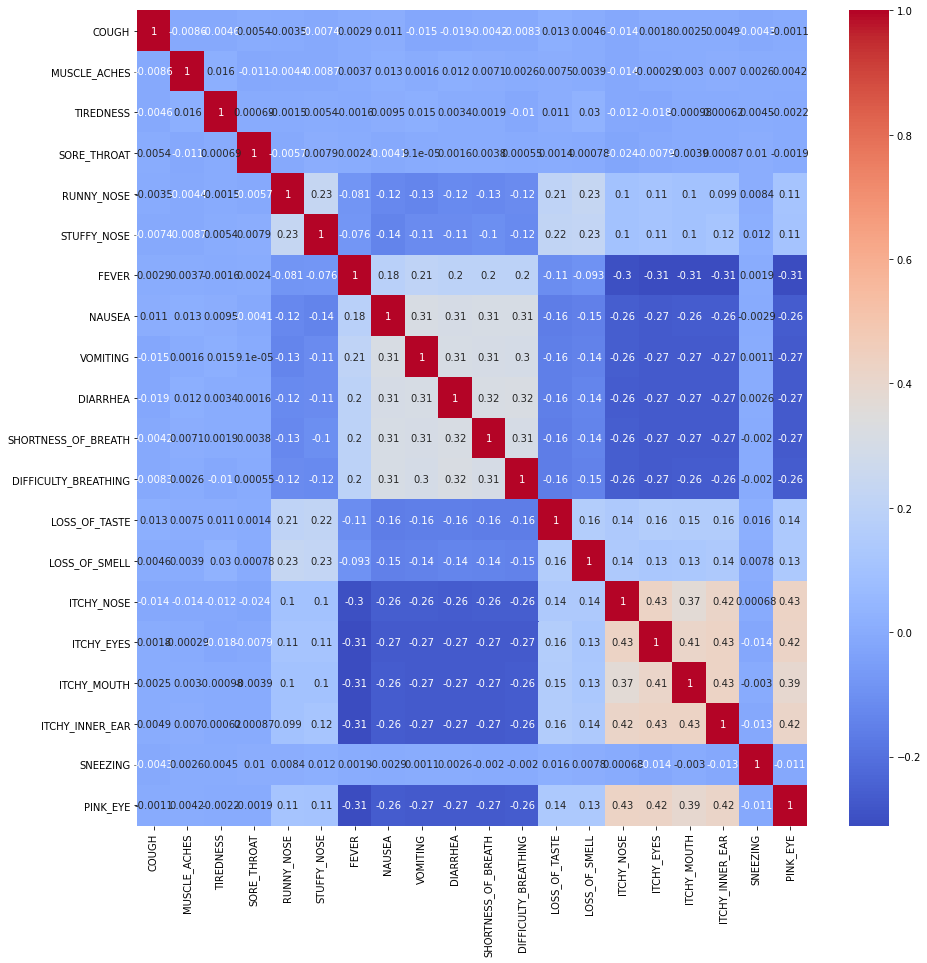

In [12]:
figure = plt.figure(figsize=(15,15))
sns.heatmap(originalData_df.corr(),annot=True, cmap='coolwarm')
plt.show()

Next, lets take a look at which symptoms present themselves based on the diagnosis. Here I display all categories where the symptom display at least once and order them from most occurences to least. As we can see, almost all symptoms display uniformly for each disease.

In [151]:
covid_df = originalData_df.loc[originalData_df['TYPE'] == 'COVID']
covid_df = covid_df.sum(axis='rows')
covid_df = covid_df.drop('TYPE')
covid_df.sort_values(ascending=False).head(12)

SHORTNESS_OF_BREATH     768
COUGH                   757
MUSCLE_ACHES            754
DIFFICULTY_BREATHING    752
TIREDNESS               749
SORE_THROAT             745
FEVER                   745
VOMITING                745
NAUSEA                  740
DIARRHEA                737
SNEEZING                734
LOSS_OF_TASTE             0
dtype: object

In [152]:
flu_df = originalData_df.loc[originalData_df['TYPE'] == 'FLU']
flu_df = flu_df.sum(axis='rows')
flu_df = flu_df.drop('TYPE')
flu_df.sort_values(ascending=False).head(16)

VOMITING                829
SNEEZING                828
STUFFY_NOSE             822
COUGH                   811
SORE_THROAT             810
SHORTNESS_OF_BREATH     800
MUSCLE_ACHES            795
NAUSEA                  794
RUNNY_NOSE              790
DIARRHEA                782
DIFFICULTY_BREATHING    768
TIREDNESS               760
FEVER                   751
LOSS_OF_TASTE           619
LOSS_OF_SMELL           603
ITCHY_NOSE                0
dtype: object

In [153]:
cold_df = originalData_df.loc[originalData_df['TYPE'] == 'COLD']
cold_df = cold_df.sum(axis='rows')
cold_df = cold_df.drop('TYPE')
cold_df.sort_values(ascending=False).head(11)

COUGH            512
MUSCLE_ACHES     512
TIREDNESS        512
SORE_THROAT      512
RUNNY_NOSE       512
LOSS_OF_SMELL    512
LOSS_OF_TASTE    512
STUFFY_NOSE      512
FEVER            512
SNEEZING         512
NAUSEA             0
dtype: object

In [154]:
allergy_df = originalData_df.loc[originalData_df['TYPE'] == 'ALLERGY']
allergy_df = allergy_df.sum(axis='rows')
allergy_df = allergy_df.drop('TYPE')
allergy_df.sort_values(ascending=False).head(15)

ITCHY_EYES             785
SNEEZING               784
ITCHY_NOSE             770
PINK_EYE               763
ITCHY_MOUTH            763
RUNNY_NOSE             762
LOSS_OF_TASTE          761
MUSCLE_ACHES           757
ITCHY_INNER_EAR        754
COUGH                  745
STUFFY_NOSE            740
TIREDNESS              733
SORE_THROAT            727
LOSS_OF_SMELL          723
SHORTNESS_OF_BREATH      0
dtype: object

### Feature selection

Going to look for features that are greater than zero for one of the types but is not in all four dataframes as this will be the features that will help our models differentiate between diagnostics. Because our data is unique in that all four of these diseases present themselves in almost exactly the same way. 

In [155]:
def isUnique(col, df1, df2, df3, df4):
    if df1.loc[col] > 0 and df2.loc[col] > 0 and df3.loc[col] > 0 and df4.loc[col] > 0:
        return False
    return True

In [156]:
columns = set()

for col in flu_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
        
for col in allergy_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
        
for col in cold_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
        
for col in covid_df.items():
    if isUnique(col[0], flu_df, allergy_df, cold_df, covid_df):
        columns.add(col[0])
print(columns)

{'NAUSEA', 'STUFFY_NOSE', 'DIARRHEA', 'LOSS_OF_SMELL', 'LOSS_OF_TASTE', 'ITCHY_NOSE', 'VOMITING', 'SHORTNESS_OF_BREATH', 'ITCHY_MOUTH', 'DIFFICULTY_BREATHING', 'ITCHY_INNER_EAR', 'RUNNY_NOSE', 'PINK_EYE', 'ITCHY_EYES', 'FEVER'}


Create a train dataframe that only has the features we want to train

In [157]:
train_df = originalData_df[columns]
train_df.shape

(5524, 15)

Need to take our target data and convert into categorical classes for our models to work with. 

In [158]:
originalData_df['TYPE_CODE'] = pd.Categorical(originalData_df['TYPE'])
originalData_df['TYPE_CODE'] = originalData_df['TYPE_CODE'].cat.codes
train_y = originalData_df['TYPE_CODE']

Splitting the data into train and test sets. I am making the test set small. This is because we removed the majority of our data to resolve it be unbalanced. But these records will be good for using as a test dataset, therefore we need less from our balanced dataset. 

In [159]:
X_train, X_test, y_train, y_test = train_test_split(train_df, train_y, test_size=0.15, random_state=4)

## Building a model

First model I want to try is a random forest. Because all of our data is binary classifications, a decision tree tends to do well at modeling clear and simply boundaries for classification. I am going with a random forest over a decision tree because they tend to be more accurate. Although they are slower than a decision tree, this is not much of a problem in this use case as scaling this model for production will not be an issue. 

In [160]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 5)
RFclassifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=5)

This code is just to print out labels for our confusion matrix below

In [161]:
label_encoder = LabelEncoder()                               
label_encoder.fit_transform(originalData_df['TYPE'])
keys = label_encoder.classes_  
values = label_encoder.transform(label_encoder.classes_)
dictionary = dict(zip(keys, values))

Our confusion matrix shows that we have perfect precision for allergies and the flu and 92% for the cold and covid. More importantly, recall for Covid is at 95% and above 90% for the rest. Our main goal is to avoid false negatives.

In [162]:
y_pred = RFclassifier.predict(X_test)
accuracyRF = sklearn.metrics.accuracy_score(y_test, y_pred)
print(dictionary)
print(sklearn.metrics.confusion_matrix(y_test,y_pred))
print(sklearn.metrics.classification_report(y_test,y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
[[230   4   0   0]
 [  0 137   0   0]
 [  0   4 205   0]
 [  0   9  19 221]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       234
           1       0.89      1.00      0.94       137
           2       0.92      0.98      0.95       209
           3       1.00      0.89      0.94       249

    accuracy                           0.96       829
   macro avg       0.95      0.96      0.96       829
weighted avg       0.96      0.96      0.96       829



Next going to try a suppor vector machine. SVM's tend to work well when there is a clear margin between classes which my initial data analysis seemed to show.

Again, high precision and recall for all diseases. These results actually match what we saw for the random forest model. 

In [163]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', C=1.0)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(dictionary)
print(sklearn.metrics.confusion_matrix(y_test,y_pred))
print(sklearn.metrics.classification_report(y_test,y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
[[230   4   0   0]
 [  0 137   0   0]
 [  0   4 205   0]
 [  0   9  19 221]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       234
           1       0.89      1.00      0.94       137
           2       0.92      0.98      0.95       209
           3       1.00      0.89      0.94       249

    accuracy                           0.96       829
   macro avg       0.95      0.96      0.96       829
weighted avg       0.96      0.96      0.96       829



lets grab the entire dataset and use it as a test dataset to further validate these models. Ideally, I should try to remove the records we used for training, but since it was a small fraction of the entire dataset and since they were randomly choosen, I am just going to use them all. 

In [164]:
finalTest_df = pd.read_csv('large_data.csv')
finalTest_df['TYPE_CODE'] = pd.Categorical(finalTest_df['TYPE'])
finalTest_df['TYPE_CODE'] = finalTest_df['TYPE_CODE'].cat.codes
finalTest_y = finalTest_df['TYPE_CODE']
finalTest_df = finalTest_df[columns]
finalTest_x = finalTest_df.values
finalTest_df.shape

(44453, 15)

First lets test our random forest model. 

In [165]:
y_pred = RFclassifier.predict(finalTest_x)
accuracyRF = sklearn.metrics.accuracy_score(finalTest_y, y_pred)
print(dictionary)
print(sklearn.metrics.confusion_matrix(finalTest_y, y_pred))
print(sklearn.metrics.classification_report(finalTest_y, y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
[[15870   511     0     0]
 [    0  1024     0     0]
 [    0    64  1984     0]
 [    0   461  1973 22566]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     16381
           1       0.50      1.00      0.66      1024
           2       0.50      0.97      0.66      2048
           3       1.00      0.90      0.95     25000

    accuracy                           0.93     44453
   macro avg       0.75      0.96      0.81     44453
weighted avg       0.97      0.93      0.94     44453



In [166]:
y_pred = svclassifier.predict(finalTest_x)
print(dictionary)
print(" ")
print(sklearn.metrics.confusion_matrix(finalTest_y, y_pred))
print(" ")
print(sklearn.metrics.classification_report(finalTest_y, y_pred))

{'ALLERGY': 0, 'COLD': 1, 'COVID': 2, 'FLU': 3}
 
[[15870   511     0     0]
 [    0  1024     0     0]
 [    0    64  1984     0]
 [    0   452  1937 22611]]
 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     16381
           1       0.50      1.00      0.67      1024
           2       0.51      0.97      0.66      2048
           3       1.00      0.90      0.95     25000

    accuracy                           0.93     44453
   macro avg       0.75      0.96      0.82     44453
weighted avg       0.97      0.93      0.94     44453



My models were able to differentiate between all four diagnosis with perfect accuracy.  